# Generate Synthetic Data

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name="spiker_segregated",
        cell= target_cell,
        sim_params= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        ),
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/model/spiker_segregated/synthetic_0.1_0.2_0.3_


(5000,)


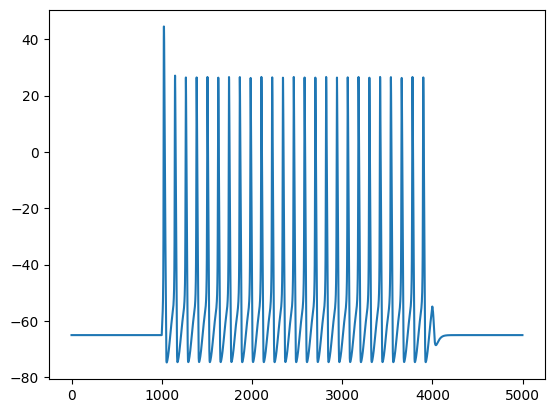

In [2]:
import numpy as np
dataset = np.load('./model/spiker_segregated/synthetic_0.1_0.2_0.3_/combined_out.npy')

V = dataset[0,:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

In [3]:
sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name="spiker_segregated",
        cell= target_cell,
        sim_params= SimParams(
            h_v_init = -65,
            h_tstop = 500,
            h_dt = 0.1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 300,
            CI_delay = 100,
            set_g_to=[]
        ),
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_segregated/synthetic_-0.1_


(5000,)


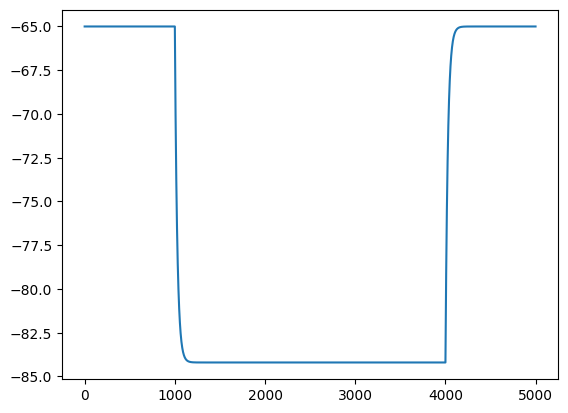

In [4]:
import numpy as np
dataset = np.loadtxt('./model/spiker_segregated/target/passive_data.csv', delimiter=',', skiprows=1)

V = dataset[:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

# Get Passive Properties

In [5]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=SimParams(
            h_v_init = -65,
            h_tstop = 500,
            h_dt = 0.1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 300,
            CI_delay = 100,
            set_g_to=[]
        ),
    trace_filepath='./model/spiker_segregated/target/passive_data.csv',
    leak_conductance_variable="gl_hh_seg",
    leak_reversal_variable="el_hh_seg"
)

In [6]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-65.0, R_in=191.99802919980584, tau=2.7, Cm=1.2664890000000124, g_bar_leak=0.00046907000000000453, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_seg', leak_reversal_variable='el_hh_seg')


# Run Original Pipeline with Passive Prediction

In [7]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

mod = ACTModule(
    ModuleParameters(
        module_folder_name="spiker_segregated",
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt= 0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        ),
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0, high=0.3, n_slices=15),
                OptimizationParam(param="gkbar_hh_seg", low=0, high=0.3, n_slices=15),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            prediction_eval_method='fi_curve'
        )
    )
)

In [8]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 675
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_segregated/train
TRAINING RANDOM FOREST REGRESSOR
-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 675/675 [06:15<00:00,  1.80it/s] 


Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
Evaluating random forest
MAE: 0.008339 (0.000940)
Predicted Conductances for each current injection intensity: 
[[0.13772143 0.04279286 0.00046907]
 [0.1311     0.0384     0.00046907]
 [0.15201429 0.02590714 0.00046907]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_segregated/prediction_eval0
/home/mwsrgf/proj/ACT/model/spiker_segregated/prediction_eval1
/home/mwsrgf/proj/ACT/model/spiker_segregated/prediction_eval2
SELECTING BEST PREDICTION
Number of spikes: [[25]
 [29]
 [31]]
Frequencies: [[ 83.33333333]
 [ 96.66666667]
 [103.33333333]]
Number of spikes: [[26]
 [29]
 [30]]
Frequencies: [[ 86.66666667]
 [ 96.66666667]
 [100.      

In [9]:
mod.pickle_rf(mod.rf_model,"./model/spiker_segregated/trained_rf.pkl")

In [10]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_file, "./model/spiker_segregated/target", "./model/spiker_segregated", [0.1,0.2,0.3])
ACTPlot.plot_fi_comparison("./model/spiker_segregated/results/frequency_data_1.npy", [0.1,0.2,0.3])

# Closer Look

0.0
[0.1311     0.0384     0.00046907]


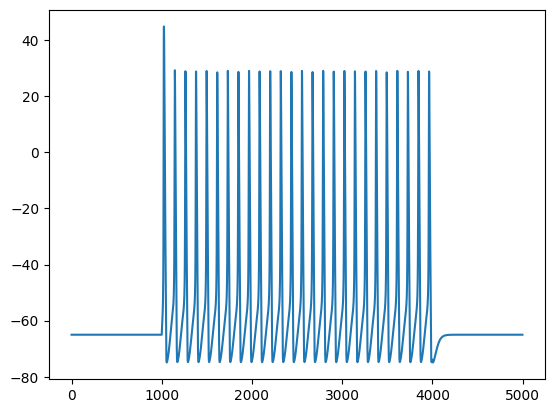

In [11]:
import numpy as np
evaluation_num = 1
dataset = np.load(f"./model/spiker_segregated/prediction_eval{evaluation_num}/combined_out.npy")
sample = 0
V = dataset[sample,:,0]
I = dataset[sample,150,1]
g = dataset[sample,:3,2]
print(I)
print(f"{g}")

from matplotlib import pyplot as plt

plt.plot(V)

(5000,)
[0.12       0.036      0.00046907]


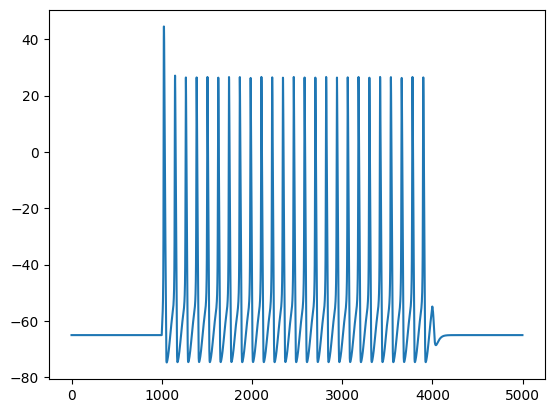

In [12]:
import numpy as np
dataset = np.load('./model/spiker_segregated/synthetic_0.1_0.2_0.3_/combined_out.npy')

sample = 0
V = dataset[sample,:,0]
g = dataset[sample,:3,2]
print(V.shape)
print(g)

from matplotlib import pyplot as plt

plt.plot(V)

In [13]:
from act.DataProcessor import DataProcessor
import numpy as np

dp = DataProcessor()

# Get Target Cell Frequencies
dataset = np.load("./model/spiker_segregated/target/combined_out.npy")

V_target = dataset[:,:,0]

target_frequencies = dp.get_fi_curve(V_target, [0.1,0.2,0.3], inj_dur=300).flatten()
print(target_frequencies)

Number of spikes: [[25]
 [29]
 [31]]
Frequencies: [[ 83.33333333]
 [ 96.66666667]
 [103.33333333]]
[ 83.33333333  96.66666667 103.33333333]
